In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
os.environ["LAL_DATA_PATH"] = "../data"

In [3]:
import bilby.gw
import gwpy
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate

/Users/keefemitman/Desktop/Research/MemoryPop/.venv/lib/python3.11/site-packages/gwpy/time/_ligotimegps.py:42: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [4]:
import sys
sys.path.insert(0, '..')

from gw_residuals import compute_one_sample_fd, compute_bbh_residuals_with_spline_calibration

In [5]:
res = compute_bbh_residuals_with_spline_calibration(
    "../data/posterior_samples_NRSur7dq4.h5",
    event="GW250114_082203",
    max_samples=10,
    thin=1
)

# Complex FD residuals: shape (nsamp, nfreq)
H1_res_fd = res["fd"]["H1"]["residual"]

res["config"]

2026-02-11  19:36:57 PESummary WARNING : Unable to install 'pycbc'. You will not be able to use some of the inbuilt functions.
2026-02-11  19:36:57 PESummary WARNING : Unable to install 'pycbc'. You will not be able to use some of the inbuilt functions.
INFO:gw_residuals:Fetching GWOSC open strain: H1 [1420878139.2, 1420878143.2), dataset=O4b3Disc
INFO:gwpy.timeseries.timeseries:Found 1 possible sources
INFO:gwpy.timeseries.timeseries:Attemping access with 'gwosc' [1/1]
INFO:gw_residuals:Fetching GWOSC open strain: L1 [1420878139.2, 1420878143.2), dataset=O4b3Disc
INFO:gwpy.timeseries.timeseries:Found 1 possible sources
INFO:gwpy.timeseries.timeseries:Attemping access with 'gwosc' [1/1]
19:37 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=4.0, sampling_frequency=4096.0, start_time=0, frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole, time_domain_source_model=None, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_pa

AnalysisConfig(label='bilby-NRSur7dq4_prod-reweighted', event='GW250114_082203', detectors=('H1', 'L1'), trigger_time=1420878141.2, start_time=1420878139.2, end_time=1420878143.2, duration=4.0, sampling_frequency=4096.0, minimum_frequency={'H1': 20.0, 'L1': 20.0}, maximum_frequency=None, reference_frequency=50.0, waveform_approximant='NRSur7dq4')

# Using the primary interface

You can use `compute_one_sample_fd()` directly for more control:

In [6]:
# Example: compute for a single sample using the primary interface
ifos = res['ifos']
wfgen = res['waveform_generator']
sample = res['samples'][0]

# This is now the primary public interface
result = compute_one_sample_fd(ifos, wfgen, sample)

# Access model and residual for each detector
for det_name, data in result.items():
    print(f"{det_name}: model shape = {data['model_fd'].shape}, residual shape = {data['residual_fd'].shape}")

H1: model shape = (8193,), residual shape = (8193,)
L1: model shape = (8193,), residual shape = (8193,)


## Plot the residual and model

Text(0.5, 0, 'Frequency bin')

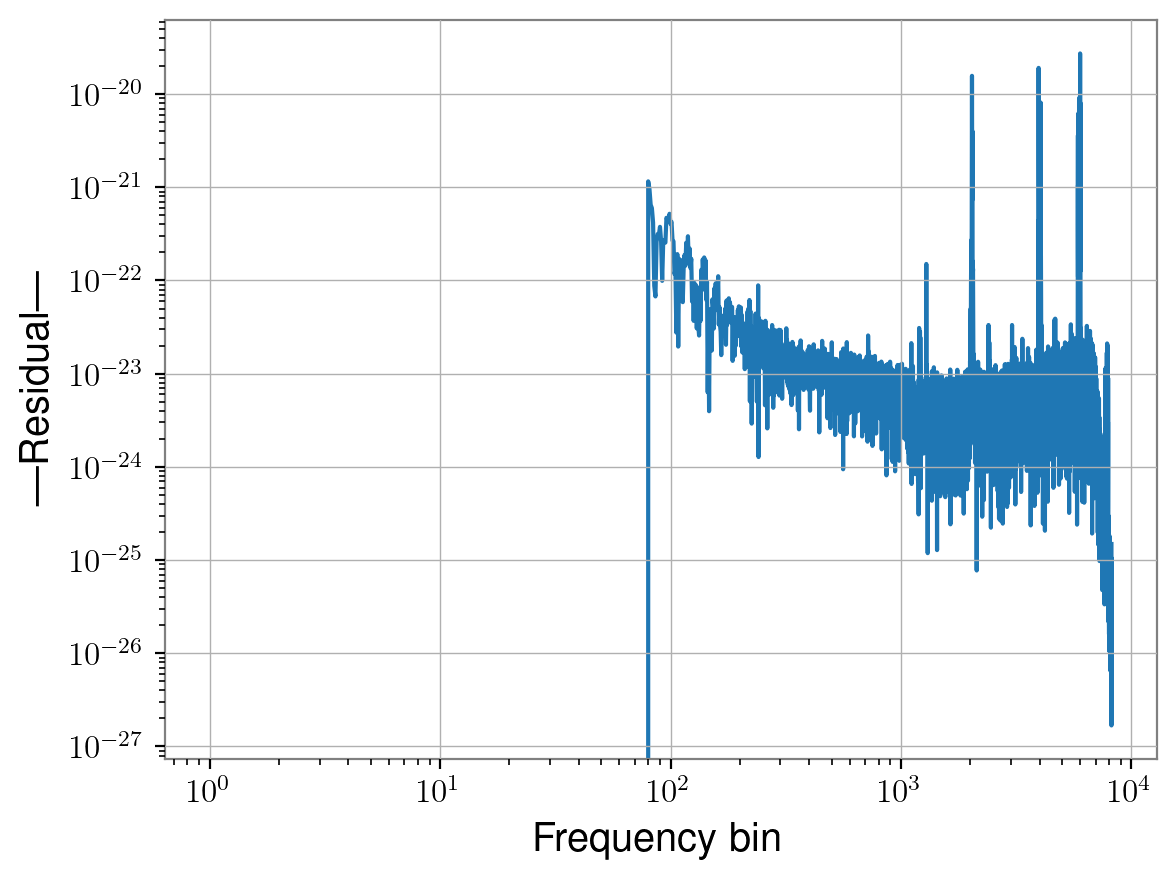

In [7]:
# Plot residual spectrum (magnitude)
plt.plot(np.abs(result['H1']['residual_fd']))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('|Residual|')
plt.xlabel('Frequency bin')

Text(0.5, 0, 'Frequency bin')

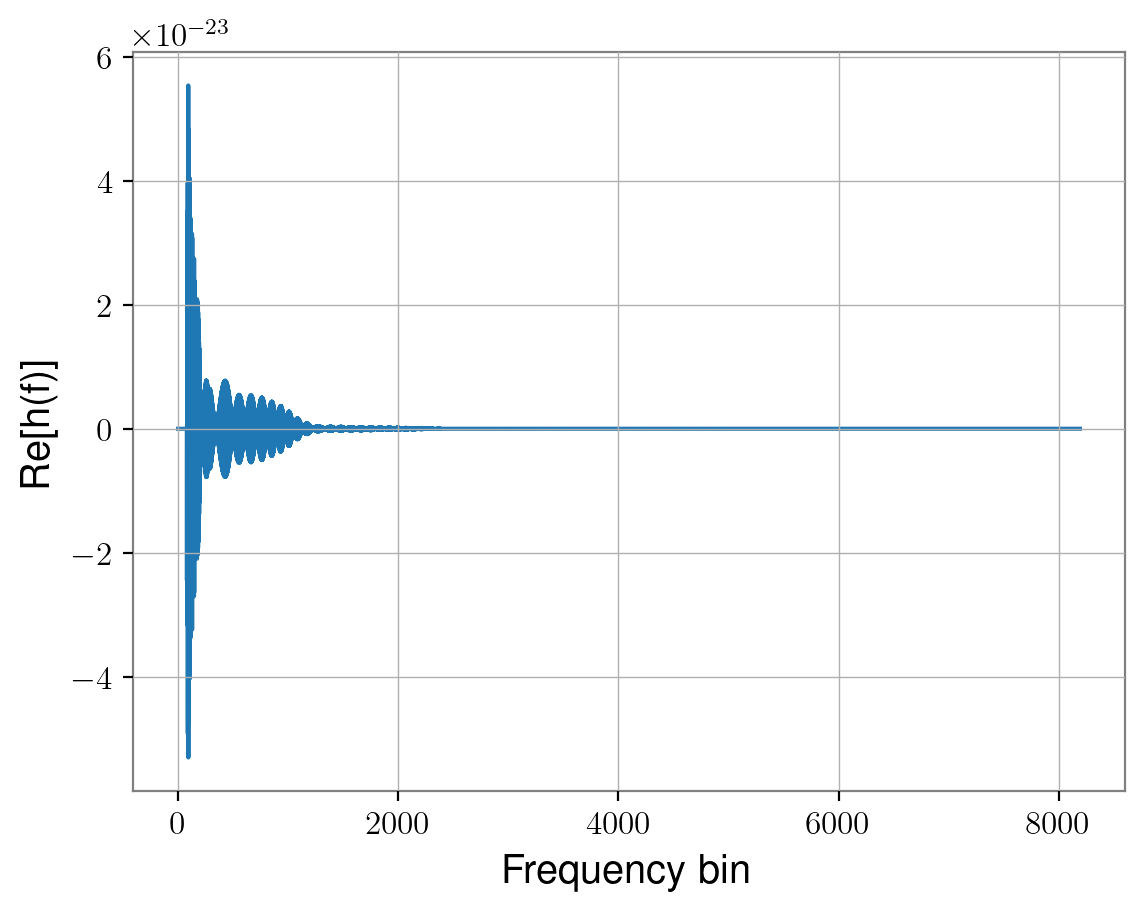

In [8]:
# Plot model waveform (real part)
plt.plot(np.real(result['H1']['model_fd']))
plt.ylabel('Re[h(f)]')
plt.xlabel('Frequency bin')

# Let's try the surrogate

In [9]:
import sys
sys.path.append('..')

In [10]:
from utils import evaluate_surrogate, evaluate_surrogate_with_LAL, compute_angular_factors, compute_memory_correction

lal.MSUN_SI != Msun


In [11]:
res.keys()

dict_keys(['config', 'ifos', 'waveform_generator', 'calibration_info', 'samples', 'fd'])

In [12]:
from pathlib import Path

# Get the notebook directory and construct path to data
notebook_dir = Path.cwd() if '__file__' not in globals() else Path(__file__).parent
data_dir = notebook_dir.parent / 'data'
path_to_surrogate = str(data_dir / 'NRSur7dq4.h5')

sample = res["samples"][0]

### Compute modes

In [13]:
h_modes, t = evaluate_surrogate(path_to_surrogate, sample, res['config'])

Loaded NRSur7dq4 model


In [14]:
h_modes_LAL, t_LAL = evaluate_surrogate_with_LAL(sample, res['config'])

compare to LAL

/Users/keefemitman/Desktop/Research/MemoryPop/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/keefemitman/Desktop/Research/MemoryPop/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


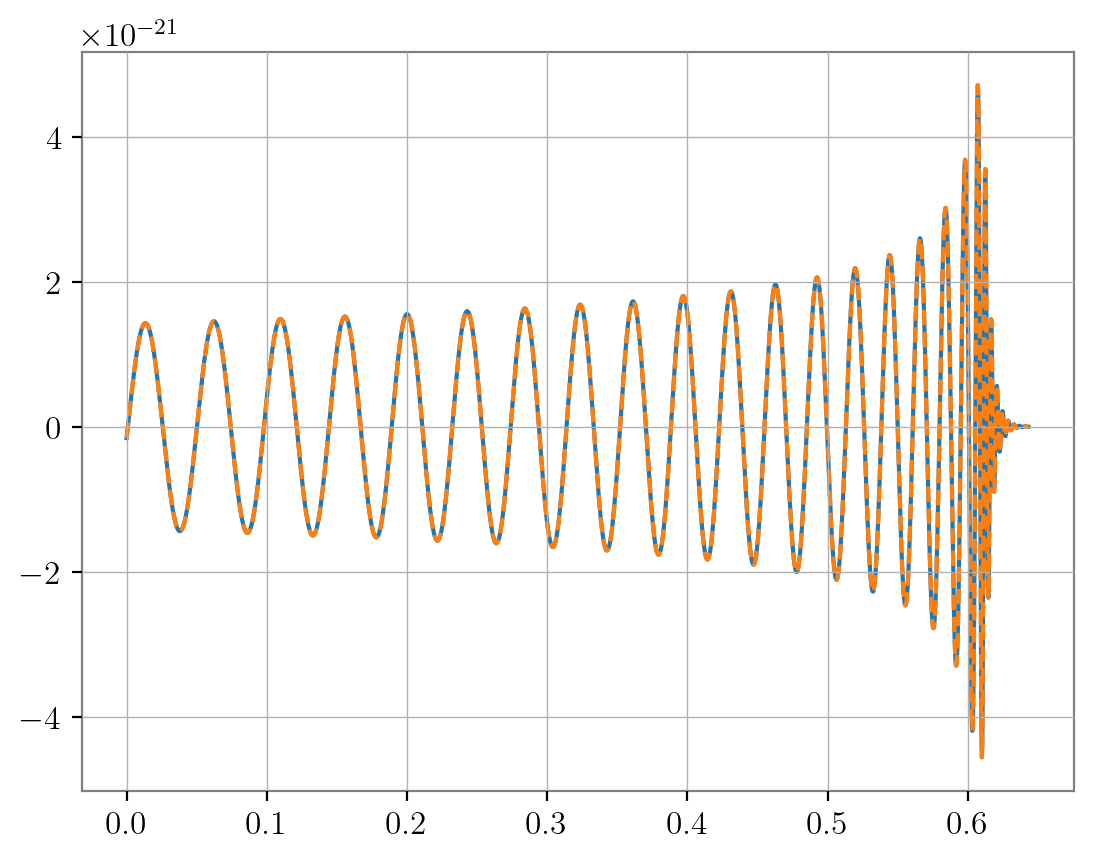

In [15]:
plt.plot(t - t[0], h_modes[(2,2)])
plt.plot(t_LAL, h_modes_LAL[(2,2)], ls='--')

Text(0, 0.5, 'percent error')

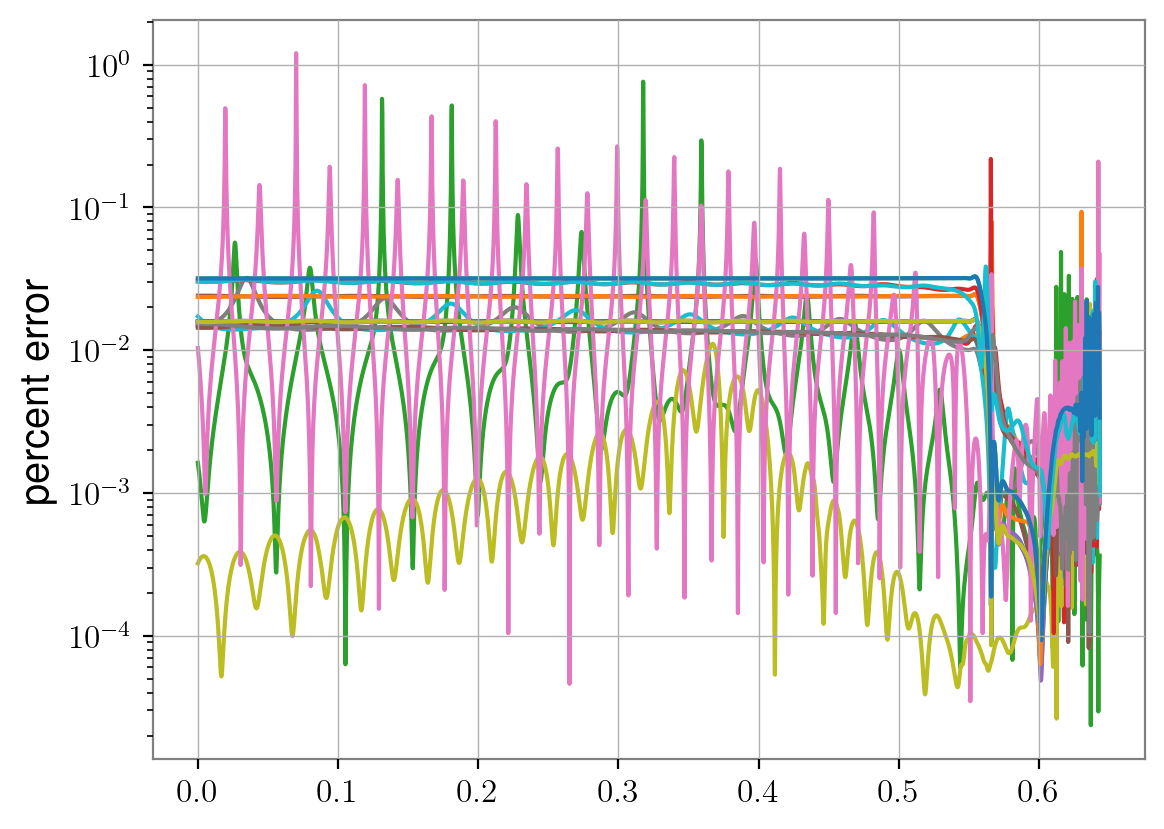

In [16]:
for L in range(2, 4 + 1):
    for M in range(-L, L + 1):
        plt.plot(t_LAL, 100*abs(h_modes[(L,M)] - h_modes_LAL[(L,M)])/abs(h_modes_LAL[(L,M)]))
        plt.yscale('log')
plt.ylabel('percent error')

precompute angular integral factors

In [17]:
angular_factors = compute_angular_factors()

compute the memory

In [18]:
h_memory = compute_memory_correction(h_modes, t, sample, angular_factors=angular_factors, return_memory_only=True)

plot it!

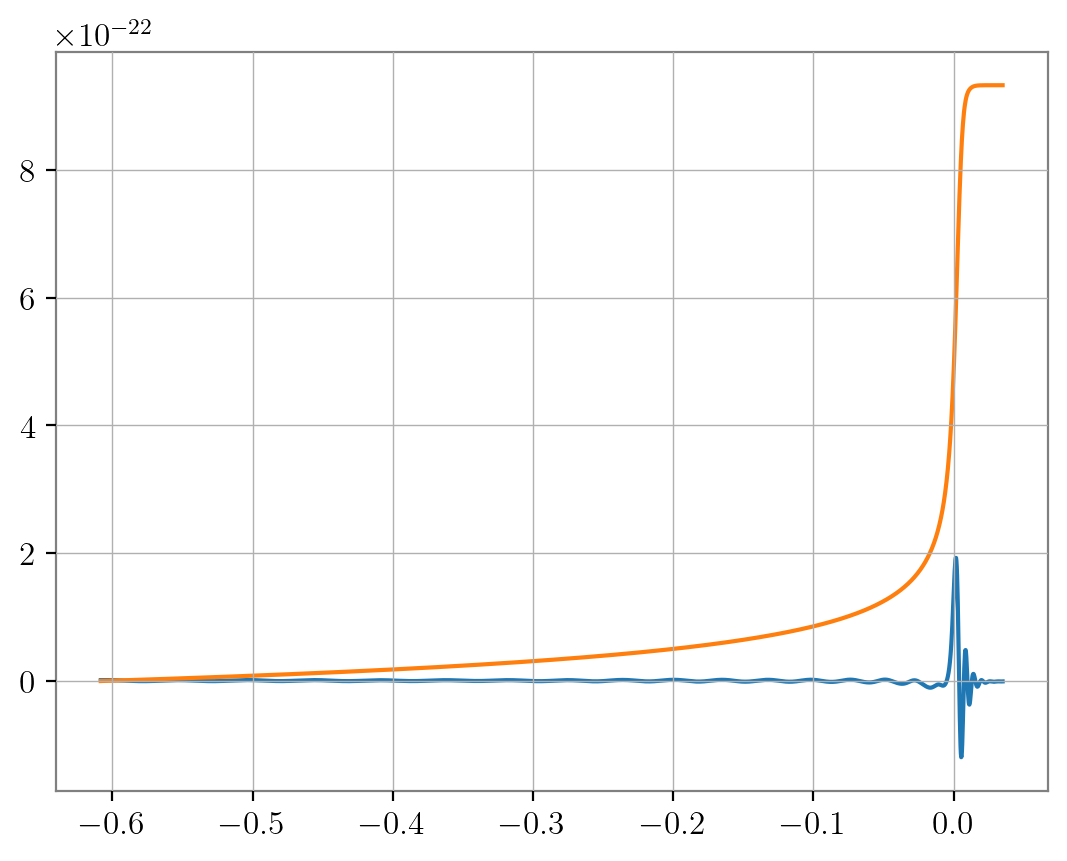

In [19]:
plt.plot(t, h_modes[(2,0)])
plt.plot(t, h_memory[(2,0)])

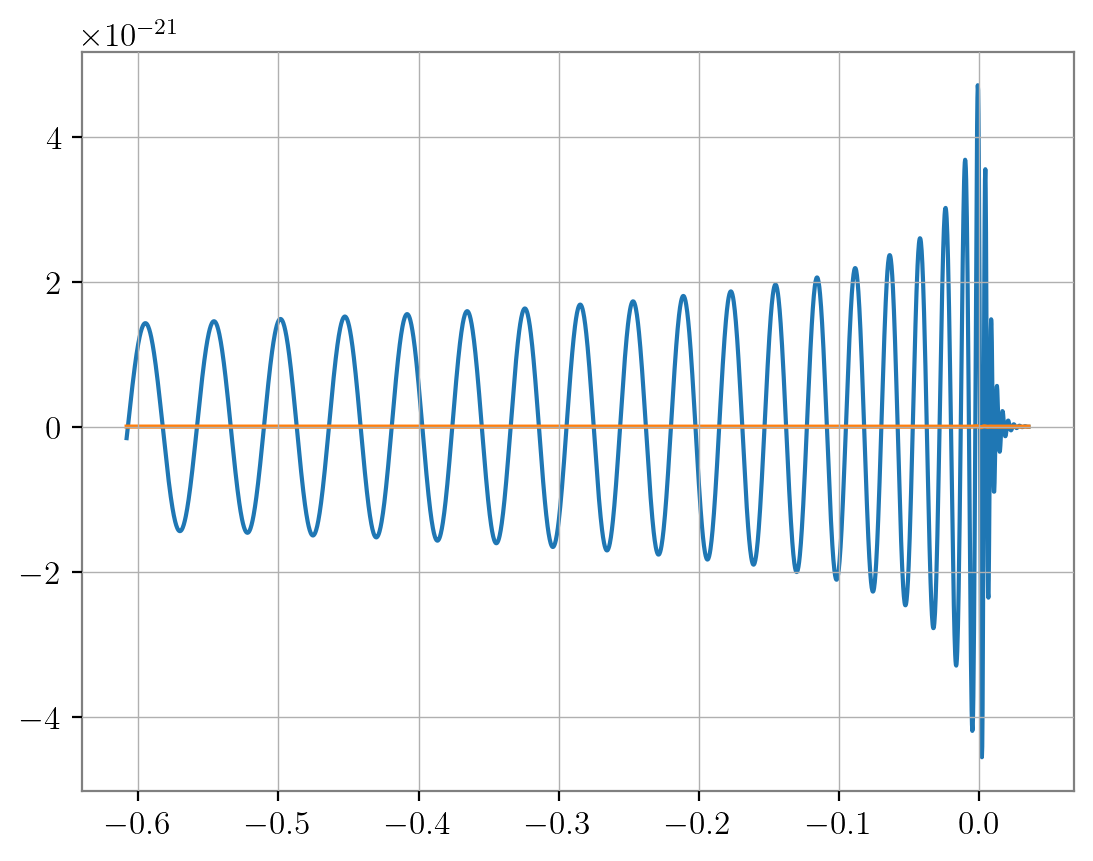

In [20]:
plt.plot(t, h_modes[(2,2)])
plt.plot(t, h_memory[(2,2)])

### Compute polarizations

In [21]:
from utils import map_modes_to_polarizations, evaluate_surrogate_with_LAL_as_polarizations

In [22]:
hp, hc = map_modes_to_polarizations(h_modes, t, sample)

In [23]:
hp_LAL, hc_LAL = evaluate_surrogate_with_LAL_as_polarizations(sample, res['config'])

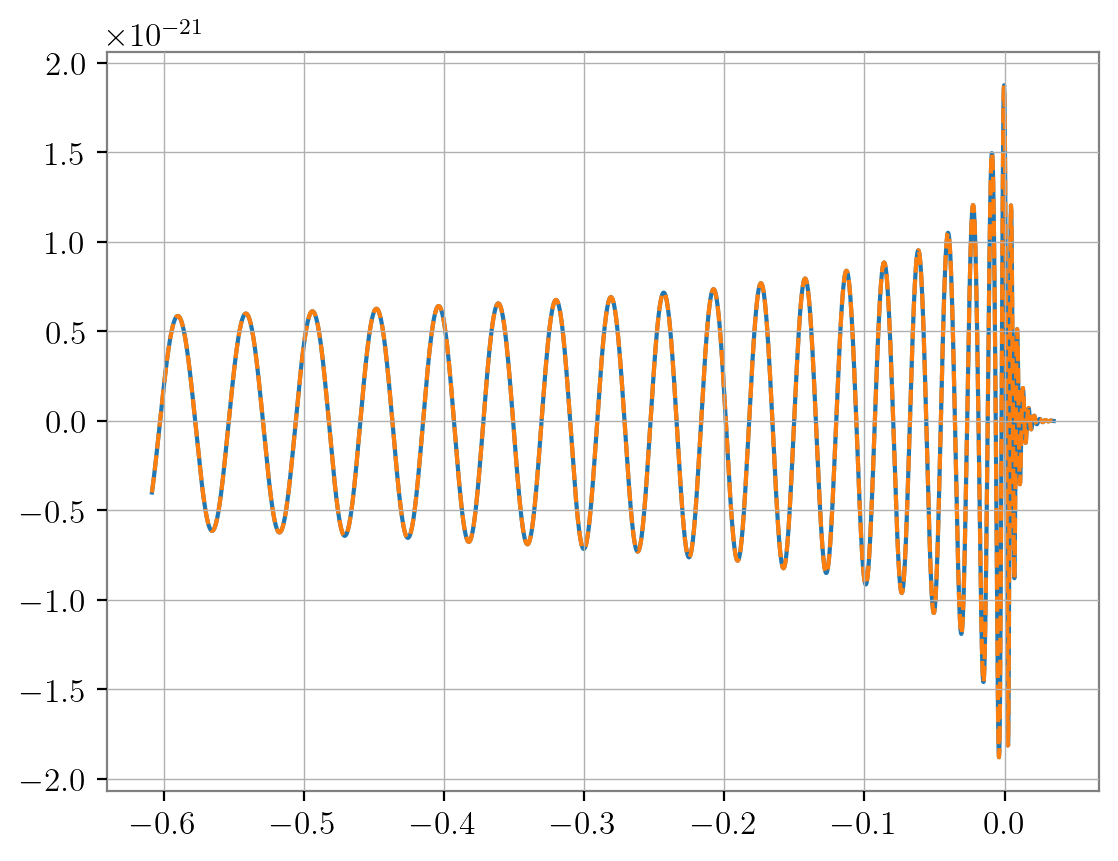

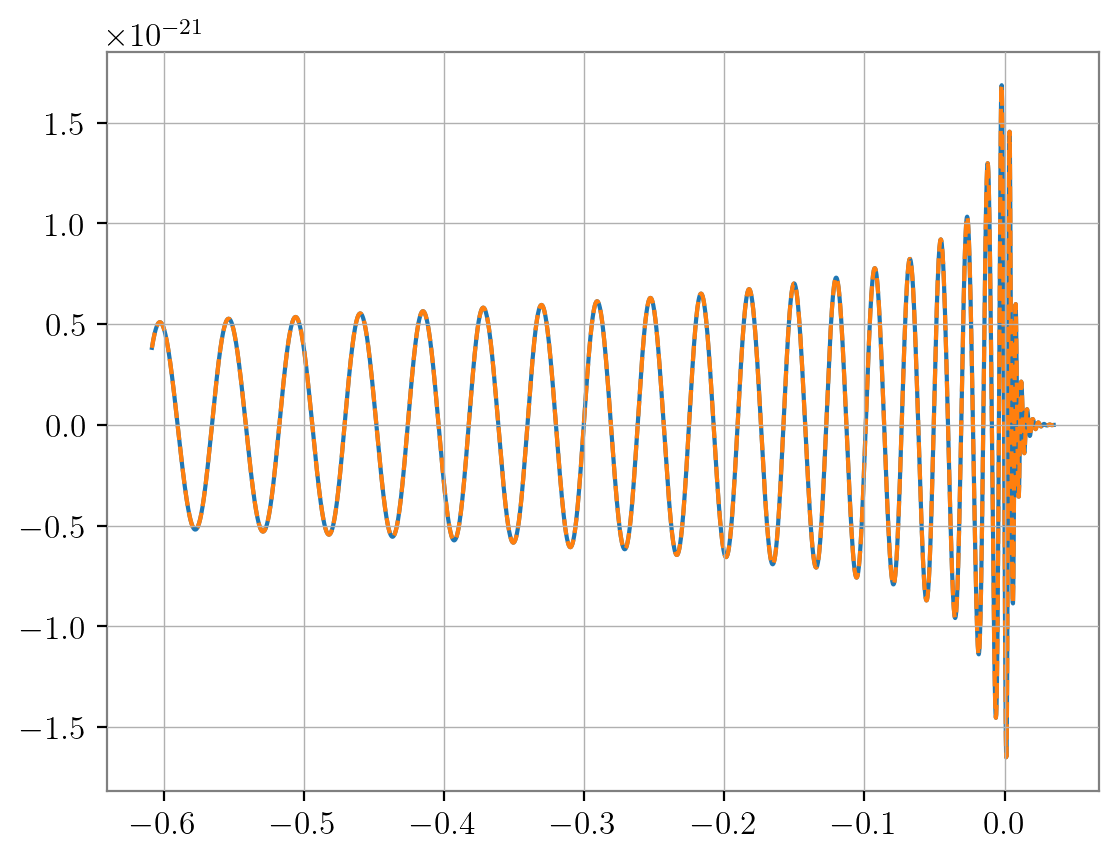

Text(0, 0.5, 'precent error')

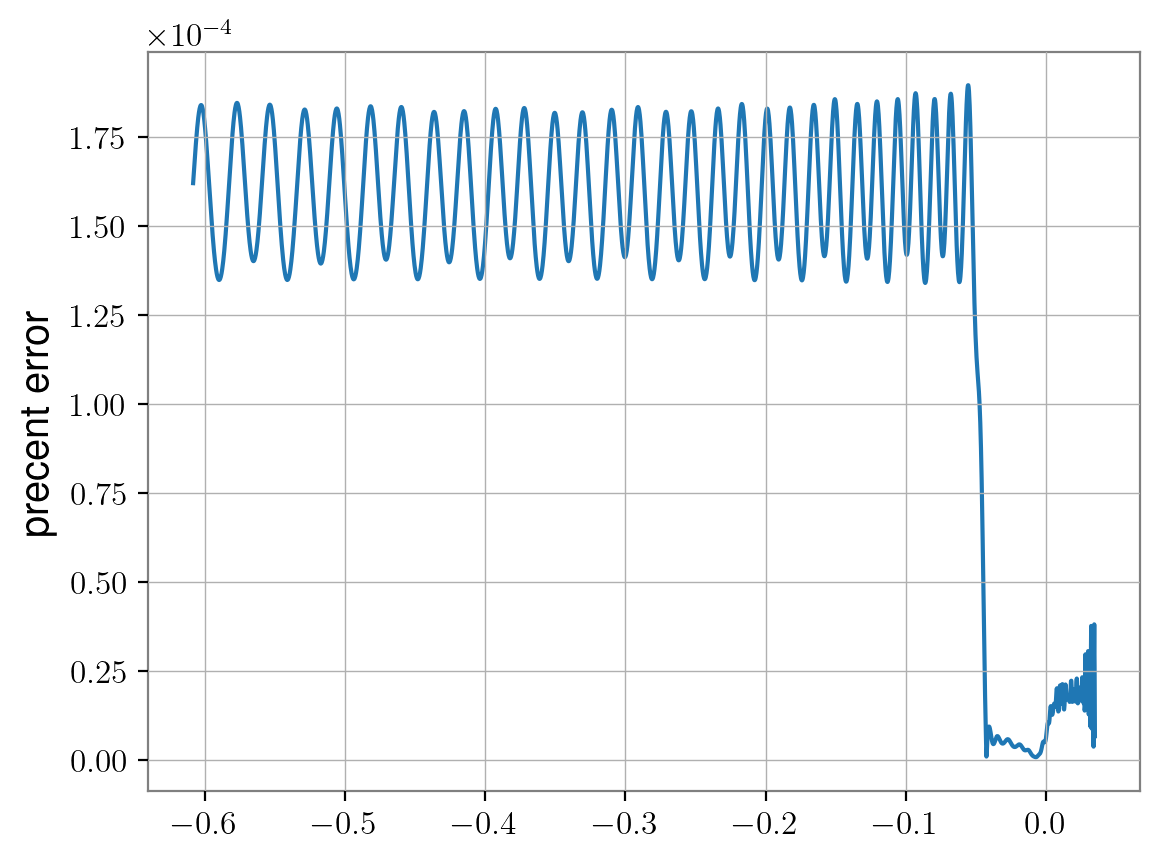

In [24]:
plt.plot(t, hp)
plt.plot(t, hp_LAL.data.data, ls='--')
plt.show()
plt.plot(t, hc)
plt.plot(t, hc_LAL.data.data, ls='--')
plt.show()
plt.plot(t, abs((hp + 1j*hc) - (hp_LAL.data.data + 1j*hc_LAL.data.data))/abs((hp_LAL.data.data + 1j*hc_LAL.data.data)))
plt.ylabel('precent error')

### Add detector response

In [25]:
import lal

In [26]:
def compute_detector_waveform(hp, hc, sample, detector):
    det = lal.CachedDetectors[detector]

    geocent_time = sample['geocent_time']
    gmst = lal.GreenwichMeanSiderealTime(geocent_time)
    
    ra  = sample['ra']
    dec = sample['dec']
    psi = sample['psi']
    
    fp, fc = lal.ComputeDetAMResponse(
        det.response,
        ra,
        dec,
        psi,
        gmst
    )
    h_det = fp * hp.data.data + fc * hc.data.data

    return h_det

In [27]:
h_det_H1 = compute_detector_waveform(hp_LAL, hc_LAL, sample, lal.LHO_4K_DETECTOR)
h_det_L1 = compute_detector_waveform(hp_LAL, hc_LAL, sample, lal.LLO_4K_DETECTOR)

In [28]:
ra  = sample['ra']
dec = sample['dec']
psi = sample['psi']
geocent_time = sample['geocent_time']

In [29]:
time_delay_H1 = lal.TimeDelayFromEarthCenter(
    lal.CachedDetectors[lal.LHO_4K_DETECTOR].location,
    ra,
    dec,
    geocent_time
)
time_delay_L1 = lal.TimeDelayFromEarthCenter(
    lal.CachedDetectors[lal.LHO_4K_DETECTOR].location,
    ra,
    dec,
    geocent_time
)

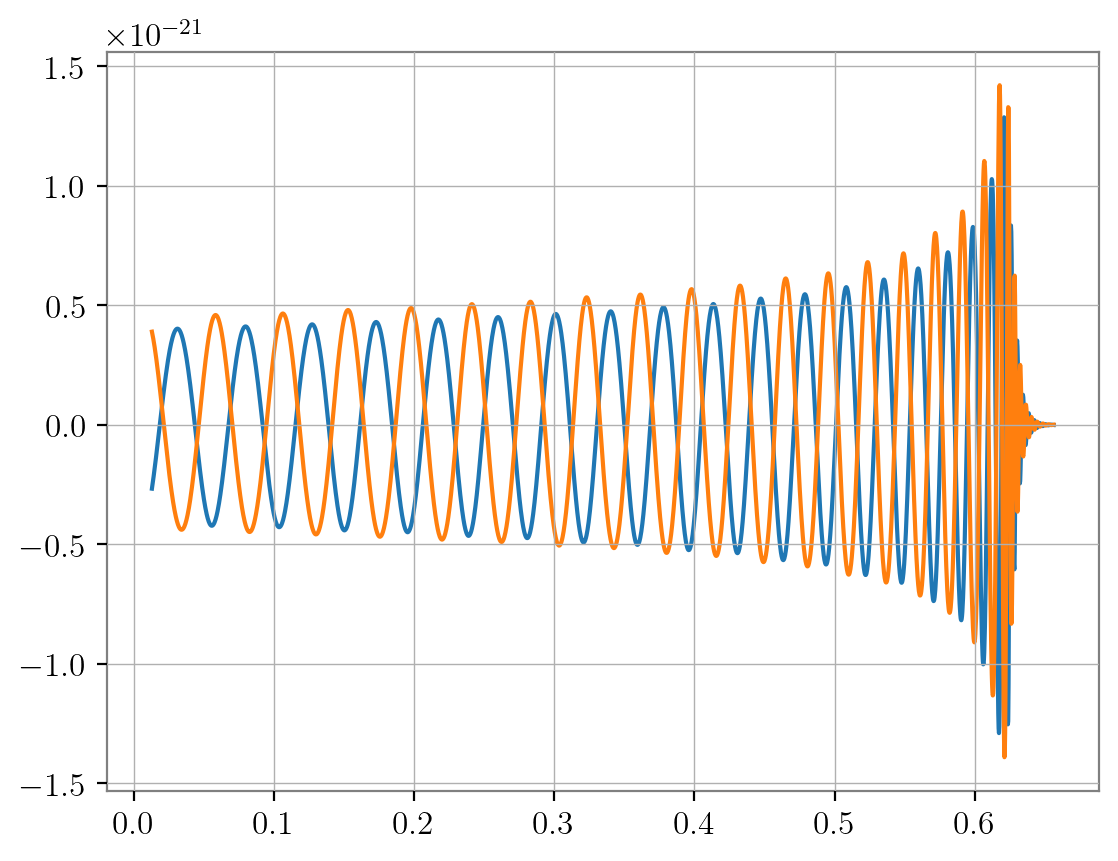

In [30]:
plt.plot(t_LAL - time_delay_H1, h_det_H1)
plt.plot(t_LAL - time_delay_L1, h_det_L1)

### Map to fourier domain

<span style="color: red;">
this currently doesn't reproduce the posterior, and the real/imaginary part differences are even worse
</span>

In [31]:
duration = res['config'].duration
fs = res['config'].sampling_frequency
deltaT = 1/fs
f_min = res['config'].minimum_frequency['H1']

N = int(duration * fs)
h_padded = np.zeros(N)

# Align merger near trigger time
start_index = N - len(h_det_H1)
h_padded[start_index:] = h_det_H1

h_fd = np.fft.rfft(h_padded) * deltaT

delta_f = 1.0 / duration
freqs = np.fft.rfftfreq(N, deltaT)

h_fd[:np.argmin(abs(freqs - f_min))] *= 0

(20.0, np.float64(3213.656464985094))

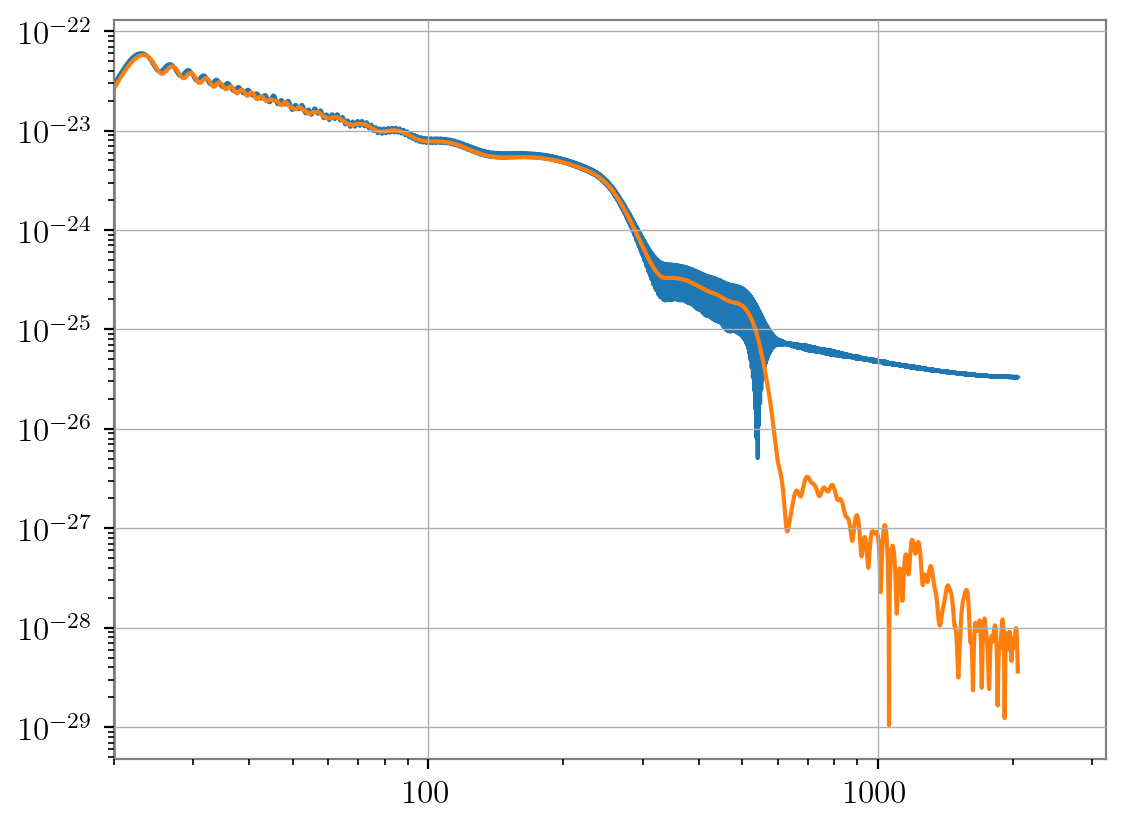

In [32]:
plt.plot(freqs, np.abs(h_fd))
plt.plot(freqs, np.abs(res['fd']['H1']['model'][0]))
plt.xscale('log')
plt.yscale('log')
plt.xlim(f_min)